## Memory & Scalability Notes

**Memory Optimizations Applied:**
- ✅ Aggressive garbage collection after data loading
- ✅ Explicit deletion of Polars DataFrames after numpy conversion
- ✅ Batch tensor cleanup in training/validation loops
- ✅ Periodic memory cleanup during training
- ✅ GPU cache clearing (if using GPU)
- ✅ Memory usage monitoring

**Scalability Considerations:**
- **Current dataset size**: 480 train samples, 60 val samples (very small)
- **Batch size**: 1024 (configurable via `BATCH_SIZE` variable)
- **Memory footprint**: ~24 features × float32 = minimal memory usage
- **OOM Risk**: **LOW** for current dataset size, but may increase with:
  - Larger datasets (>100K samples)
  - More features (if expanded beyond 24)
  - Larger batch sizes
  
**If OOM occurs:**
1. Reduce `BATCH_SIZE` (try 512, 256, or 128)
2. Process validation in smaller chunks
3. Use gradient accumulation for effective larger batches
4. Consider using `torch.no_grad()` more aggressively
5. Monitor memory with `memory_usage()` calls


## 1. Setup

In [1]:
import os
from pathlib import Path
import random
import gc
import numpy as np
import polars as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# Device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
# Paths (adapt if your project structure differs)
# Try to find project root by looking for 'data' directory
current = Path(os.getcwd())
PROJECT_ROOT = current
# Go up directories until we find one with 'data' subdirectory
for _ in range(5):  # Max 5 levels up
    if (PROJECT_ROOT / 'data').exists():
        break
    PROJECT_ROOT = PROJECT_ROOT.parent
else:
    # Fallback: assume we're in src/notebooks, go up 2 levels
    PROJECT_ROOT = current.parent.parent
MODEL_READY_DIR = PROJECT_ROOT / 'data' / 'model_ready'
utils_path = PROJECT_ROOT / 'src' / 'utils'
print('PROJECT_ROOT:', PROJECT_ROOT)
print('MODEL_READY_DIR:', MODEL_READY_DIR)
# Import memory utilities from shared module
import sys
if utils_path.exists():
    sys.path.insert(0, str(utils_path))
try:
    from model_training_utils import cleanup_memory, memory_usage
    print("✅ Memory utilities imported from shared module")
except ImportError:
    # Fallback definitions if utils not available
    def cleanup_memory():
        """Aggressive memory cleanup for both CPU and GPU."""
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()  # Second pass for thorough cleanup
    def memory_usage():
        """Display current memory usage statistics."""
        try:
            import psutil
            process = psutil.Process(os.getpid())
            mem_info = process.memory_info()
            print(f"💾 Memory: {mem_info.rss / 1024**3:.2f} GB (RAM)", end="")
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated() / 1024**3
                gpu_reserved = torch.cuda.memory_reserved() / 1024**3
                print(f" | {gpu_mem:.2f}/{gpu_reserved:.2f} GB (GPU used/reserved)")
            else:
                print()
        except ImportError:
            print("💾 Memory tracking requires psutil: pip install psutil")
    print("⚠️ Using fallback memory utilities")


Using device: cuda
PROJECT_ROOT: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2
MODEL_READY_DIR: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready
✅ Memory utilities imported from shared module


## 2. Dataset & utilities

In [2]:
class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
def load_parquet_split(split: str) -> pl.DataFrame:
    """Load a model_ready parquet split (train/val/test)."""
    path = MODEL_READY_DIR / f'{split}_model_ready_reduced.parquet'
    if not path.exists():
        # Fallback to non-reduced files if needed
        alt = MODEL_READY_DIR / f'{split}_model_ready.parquet'
        if not alt.exists():
            raise FileNotFoundError(f'Could not find {path} or {alt}')
        path = alt
    print(f'Loading {split} from {path}')
    return pl.read_parquet(path)
# Feature selection: non-embedding numeric features only
EMBEDDING_PREFIXES = ['sent_transformer_', 'scibert_', 'specter_', 'specter2_', 'ner_']
# Numeric dtypes in Polars
NUMERIC_DTYPES = {
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64
}
def select_features_non_embedding(df: pl.DataFrame):
    cols = df.columns
    dtypes = df.dtypes
    label = df['label'].to_numpy() if 'label' in cols else None
    feature_cols = []
    for c, dt in zip(cols, dtypes):
        if c in ('id', 'label'):
            continue
        if any(c.startswith(p) for p in EMBEDDING_PREFIXES):
            continue
        # Only include numeric columns
        if dt in NUMERIC_DTYPES:
            feature_cols.append(c)
    X = df.select(feature_cols).to_numpy()
    return X, label, feature_cols
def make_dataloaders(X_train, y_train, X_val, y_val, batch_size: int = 512, val_batch_size: int = None, num_workers: int = 0):
    """
    Create DataLoaders with memory-efficient settings for large datasets.
    Args:
        batch_size: Training batch size (default 512 for large datasets)
        val_batch_size: Validation batch size (defaults to batch_size if None)
        num_workers: Number of worker processes (0 to avoid multiprocessing overhead)
    """
    if val_batch_size is None:
        val_batch_size = batch_size
    # Compute sample weights for WeightedRandomSampler (handle class imbalance)
    class_sample_counts = np.bincount(y_train.astype(int))
    print('Class counts (train):', class_sample_counts)
    # Avoid division by zero
    weights_per_class = 1.0 / np.maximum(class_sample_counts, 1)
    sample_weights = weights_per_class[y_train.astype(int)]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_dataset = TabularDataset(X_train, y_train)
    val_dataset = TabularDataset(X_val, y_val)
    # Use num_workers=0 to avoid multiprocessing memory overhead
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=False  # Disable pin_memory to save memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=False
    )
    return train_loader, val_loader
# Load train/val splits
train_df = load_parquet_split('train')
val_df = load_parquet_split('val')
X_train, y_train, feature_cols = select_features_non_embedding(train_df)
X_val, y_val, _ = select_features_non_embedding(val_df)
# Clean up Polars DataFrames immediately after conversion
del train_df, val_df
cleanup_memory()
print('Selected non-embedding feature count:', len(feature_cols))
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)
memory_usage()
# Configurable batch size - reduce if OOM occurs
# Configurable batch sizes - optimized for large datasets (960k train, 100k val)
# Reduce if OOM occurs
BATCH_SIZE = 512  # Training batch size (reduced for large datasets)
VAL_BATCH_SIZE = 512  # Validation batch size (can be larger since no gradients)
NUM_WORKERS = 0  # Set to 0 to avoid multiprocessing memory overhead
print(f'\n📊 DataLoader Configuration:')
print(f'   Train batch size: {BATCH_SIZE}')
print(f'   Val batch size: {VAL_BATCH_SIZE}')
print(f'   Num workers: {NUM_WORKERS} (0 = single process, saves memory)')
train_loader, val_loader = make_dataloaders(
    X_train, y_train, X_val, y_val,
    batch_size=BATCH_SIZE,
    val_batch_size=VAL_BATCH_SIZE,
    num_workers=NUM_WORKERS
)
cleanup_memory()
memory_usage()


Loading train from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/train_model_ready.parquet


Loading val from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/val_model_ready.parquet


Selected non-embedding feature count: 54
Train shape: (960000, 54) Val shape: (120000, 54)
💾 Memory: 17.17 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)

📊 DataLoader Configuration:
   Train batch size: 512
   Val batch size: 512
   Num workers: 0 (0 = single process, saves memory)
Class counts (train): [894192  65808]


💾 Memory: 17.38 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


LinearClassifier(
  (linear): Linear(in_features=54, out_features=1, bias=True)
)


Epoch 01 | train_loss=5.1912 | val_f1=0.2470 @ thr=0.90 | roc_auc=0.8522 | pr_auc=0.2419
💾 Memory: 17.61 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 02 | train_loss=1.3396 | val_f1=0.2539 @ thr=0.90 | roc_auc=0.8767 | pr_auc=0.3161
💾 Memory: 17.61 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 03 | train_loss=1.2957 | val_f1=0.2454 @ thr=0.90 | roc_auc=0.8708 | pr_auc=0.2780
💾 Memory: 17.61 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 04 | train_loss=1.2960 | val_f1=0.2922 @ thr=0.90 | roc_auc=0.8784 | pr_auc=0.3238
💾 Memory: 17.60 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 05 | train_loss=1.2848 | val_f1=0.3275 @ thr=0.90 | roc_auc=0.8811 | pr_auc=0.3214
💾 Memory: 17.33 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 06 | train_loss=1.2722 | val_f1=0.3143 @ thr=0.90 | roc_auc=0.8807 | pr_auc=0.3228
💾 Memory: 17.32 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 07 | train_loss=1.2822 | val_f1=0.3253 @ thr=0.90 | roc_auc=0.8808 | pr_auc=0.3169
💾 Memory: 17.30 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 08 | train_loss=1.2648 | val_f1=0.3600 @ thr=0.90 | roc_auc=0.8812 | pr_auc=0.3189
💾 Memory: 17.30 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 09 | train_loss=1.2671 | val_f1=0.3088 @ thr=0.90 | roc_auc=0.8778 | pr_auc=0.3199
💾 Memory: 17.29 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Epoch 10 | train_loss=1.2576 | val_f1=0.2969 @ thr=0.90 | roc_auc=0.8814 | pr_auc=0.3180
💾 Memory: 17.15 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Best val F1: 0.3600101268671411



💾 Saved best model to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/models/saved_models/model1_regular_no_embeddings_best.pt

Validation classification report (best model, thr=0.5 for reference):


              precision    recall  f1-score   support

         0.0     0.9984    0.3587    0.5278    111925
         1.0     0.1004    0.9918    0.1823      8075

    accuracy                         0.4013    120000
   macro avg     0.5494    0.6753    0.3551    120000
weighted avg     0.9379    0.4013    0.5046    120000


ROC-AUC: 0.8814
Precision-Recall AUC: 0.3180


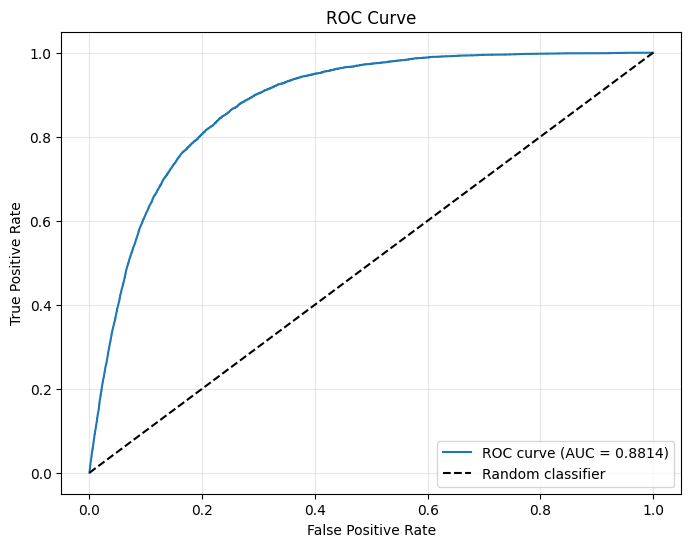

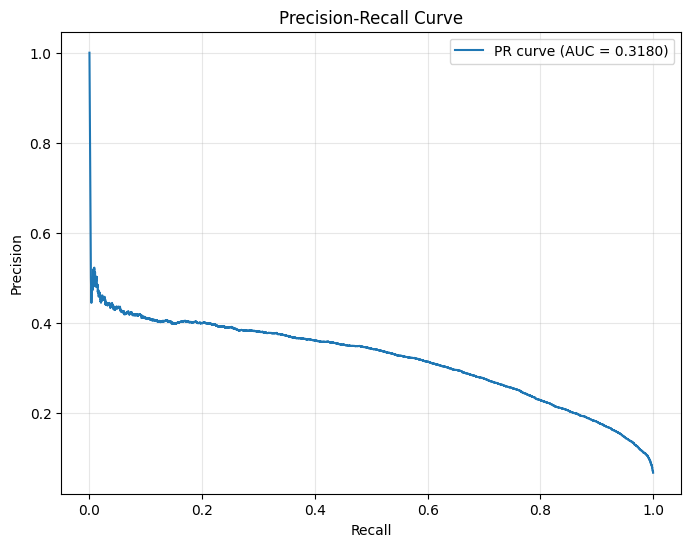

💾 Memory: 17.15 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


In [3]:
## 3. Model definition
class LinearClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)
input_dim = X_train.shape[1]
model = LinearClassifier(input_dim)
model = model.to(device)
print(model)
## 4. Train / validation loop
EPOCHS = 10
LR = 1e-3
# Compute pos_weight for BCEWithLogitsLoss (handle class imbalance explicitly)
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
pos_weight_value = torch.tensor([neg_count / max(pos_count, 1)], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_val_f1 = 0.0
best_state_dict = None
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    # Training loop with cleanup
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        # Clean up batch tensors
        del xb, yb, logits, loss
        if epoch % 5 == 0:  # Periodic cleanup during training
            cleanup_memory()
    avg_train_loss = running_loss / len(train_loader.dataset)
    # Validation with memory-efficient accumulation (critical for 100k val samples)
    model.eval()
    all_preds = []
    all_targets = []
    batch_count = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb_np = yb.numpy()  # Convert before moving to device
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_preds.append(probs)
            all_targets.append(yb_np)
            # Clean up batch tensors immediately
            del xb, logits, probs, yb_np
            batch_count += 1
            # Periodic cleanup during validation for large datasets
            if batch_count % 50 == 0:  # Every 50 batches
                cleanup_memory()
    # Concatenate only once
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    # Threshold tuning for F1 on positive class
    # Calculate ROC-AUC and Precision-Recall AUC (using probabilities, not binary predictions)
    roc_auc = roc_auc_score(all_targets, all_preds)
    pr_auc = average_precision_score(all_targets, all_preds)
    best_epoch_f1 = 0.0
    best_thr = 0.5
    thresholds = np.linspace(0.1, 0.9, 17)
    for thr in thresholds:
        # Compute binary predictions without storing intermediate array
        preds_bin = (all_preds >= thr).astype(int)
        f1 = f1_score(all_targets, preds_bin, pos_label=1)
        if f1 > best_epoch_f1:
            best_epoch_f1 = f1
            best_thr = thr
        del preds_bin  # Clean up immediately
    # Clean up concatenated arrays
    del all_preds, all_targets
    print(f'Epoch {epoch:02d} | train_loss={avg_train_loss:.4f} | val_f1={best_epoch_f1:.4f} @ thr={best_thr:.2f} | roc_auc={roc_auc:.4f} | pr_auc={pr_auc:.4f}')
    # Always print memory for large datasets to monitor OOM risk
    memory_usage()
    if best_epoch_f1 > best_val_f1:
        best_val_f1 = best_epoch_f1
        best_state_dict = model.state_dict().copy()  # Explicit copy to avoid references
    # Aggressive cleanup after each epoch (critical for large datasets)
    cleanup_memory()
print('Best val F1:', best_val_f1)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    # Save the best model
    MODEL_SAVE_DIR = PROJECT_ROOT / 'models' / 'saved_models'
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    model_save_path = MODEL_SAVE_DIR / 'model1_regular_no_embeddings_best.pt'
    torch.save({
        'model_state_dict': best_state_dict,
        'input_dim': input_dim,
        'best_val_f1': best_val_f1,
        'epochs': EPOCHS,
        'learning_rate': LR,
        'pos_weight': pos_weight_value.cpu().item() if hasattr(pos_weight_value, 'cpu') else pos_weight_value.item()
    }, model_save_path)
    print(f'\n💾 Saved best model to: {model_save_path}')
print('\nValidation classification report (best model, thr=0.5 for reference):')
# Validation with memory-efficient accumulation (critical for 100k val samples)
model.eval()
all_preds = []
all_targets = []
batch_count = 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb_np = yb.numpy()  # Convert before moving to device
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_preds.append(probs)
        all_targets.append(yb_np)
        # Clean up batch tensors immediately
        del xb, logits, probs, yb_np
        batch_count += 1
        # Periodic cleanup during validation for large datasets
        if batch_count % 50 == 0:  # Every 50 batches
            cleanup_memory()
# Concatenate only once
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
# Generate predictions for classification report (threshold 0.5)
preds_bin = (all_preds >= 0.5).astype(int)
print(classification_report(all_targets, preds_bin, digits=4, zero_division=0))
# Calculate ROC-AUC and Precision-Recall AUC
roc_auc = roc_auc_score(all_targets, all_preds)
pr_auc = average_precision_score(all_targets, all_preds)
print(f'\nROC-AUC: {roc_auc:.4f}')
print(f'Precision-Recall AUC: {pr_auc:.4f}')
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Final cleanup
del all_preds, all_targets, preds_bin
cleanup_memory()
memory_usage()


## 4. 5-Fold Cross-Validation with Hyperparameter Tuning

This section implements:
- 5-fold cross-validation
- Limited hyperparameter search (for 3-hour constraint)
- Model weight saving
- Threshold fine-tuning


In [4]:
import sys
import numpy as np
import time
import json
# PyTorch-friendly stratified splits (no sklearn dependency)
# Add utils to path
# Ensure PROJECT_ROOT is defined (should be set in setup cell)
if 'PROJECT_ROOT' not in globals():
    from pathlib import Path
    import os
    current = Path(os.getcwd())
    PROJECT_ROOT = current
    for _ in range(5):
        if (PROJECT_ROOT / 'data').exists():
            break
        PROJECT_ROOT = PROJECT_ROOT.parent
    else:
        PROJECT_ROOT = current.parent.parent
utils_path = PROJECT_ROOT / 'src' / 'utils'
if utils_path.exists():
    sys.path.insert(0, str(utils_path))
try:
    from model_training_utils import (
        find_optimal_threshold, cross_validate,
        generate_submission, save_model_weights,
        stratified_kfold_splits
    )
    print("✅ Utility functions imported")
except ImportError as e:
    print(f"⚠️ Could not import utilities: {e}")
    print("Will use inline implementations")
# Combine train and val for CV
X_full = np.vstack([X_train, X_val])
y_full = np.hstack([y_train, y_val])
print(f"\n📊 Full dataset for CV: {X_full.shape}, labels: {y_full.shape}")
# Limited hyperparameter search space for 3-hour constraint
HYPERPARAMETER_GRID = [
    {'lr': 1e-3, 'batch_size': 512},
    {'lr': 5e-4, 'batch_size': 512},
    {'lr': 1e-3, 'batch_size': 256},
]
print(f"\n🔍 Hyperparameter grid ({len(HYPERPARAMETER_GRID)} combinations):")
for i, hp in enumerate(HYPERPARAMETER_GRID, 1):
    print(f"  {i}. LR={hp['lr']}, Batch={hp['batch_size']}")
cleanup_memory()
memory_usage()


✅ Utility functions imported



📊 Full dataset for CV: (1080000, 54), labels: (1080000,)

🔍 Hyperparameter grid (3 combinations):
  1. LR=0.001, Batch=512
  2. LR=0.0005, Batch=512
  3. LR=0.001, Batch=256
💾 Memory: 17.59 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


In [5]:
# 5-fold CV with hyperparameter tuning
import time
best_hyperparams = None
best_cv_score = 0.0
best_model_state = None
best_threshold = 0.5
cv_start_time = time.time()
for hp_idx, hyperparams in enumerate(HYPERPARAMETER_GRID, 1):
    print(f"\n{'='*80}")
    print(f"Hyperparameter Set {hp_idx}/{len(HYPERPARAMETER_GRID)}: {hyperparams}")
    print(f"{'='*80}")
    # Update batch size
    BATCH_SIZE = hyperparams['batch_size']
    VAL_BATCH_SIZE = hyperparams['batch_size']
    # Create dataloader factory function
    def make_dataloaders_cv(X_tr, y_tr, X_v, y_v):
        return make_dataloaders(
            X_tr, y_tr, X_v, y_v,
            batch_size=BATCH_SIZE,
            val_batch_size=VAL_BATCH_SIZE,
            num_workers=NUM_WORKERS
        )
    # Compute pos_weight
    pos_count = (y_full == 1).sum()
    neg_count = (y_full == 0).sum()
    pos_weight_value = torch.tensor([neg_count / max(pos_count, 1)], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)
    # CV using utility function
    try:
        cv_results = cross_validate(
            model_class=LinearClassifier,
            model_kwargs={'input_dim': X_full.shape[1]},
            X_train=X_full,
            y_train=y_full,
            make_dataloaders_func=make_dataloaders_cv,
            criterion=criterion,
            optimizer_class=torch.optim.Adam,
            optimizer_kwargs={'lr': hyperparams['lr']},
            device=device,
            n_splits=5,
            epochs=15,  # Reduced for time constraint
            early_stopping_patience=3,  # Aggressive early stopping
            verbose=True
        )
        print(f"\n📊 CV Results for {hyperparams}:")
        print(f"  Mean F1: {cv_results['mean_f1']:.4f} ± {cv_results['std_f1']:.4f}")
        print(f"  Mean Threshold: {cv_results['mean_threshold']:.4f}")
        if cv_results['mean_f1'] > best_cv_score:
            best_cv_score = cv_results['mean_f1']
            best_hyperparams = hyperparams
            best_model_state = cv_results['best_model_state']
            best_threshold = cv_results['mean_threshold']
            print(f"  ✅ New best!")
    except Exception as e:
        print(f"  ❌ Error during CV: {e}")
        import traceback
        traceback.print_exc()
    cleanup_memory()
cv_time = time.time() - cv_start_time
# Verify CV completed successfully
if best_model_state is None:
    print("⚠️ WARNING: CV loop completed but best_model_state is None!")
    print("This may indicate all hyperparameter combinations failed or no improvement was found.")
    print("Creating a default model for threshold tuning...")
    # Create a default model as fallback
    temp_model = LinearClassifier(input_dim=X_full.shape[1]).to(device)
    best_model_state = temp_model.state_dict()
    best_hyperparams = HYPERPARAMETER_GRID[0] if HYPERPARAMETER_GRID else {"lr": 1e-3, "batch_size": 512}
    best_cv_score = 0.0
    best_threshold = 0.5
print(f"\n{'='*80}")
print(f"✅ CV Complete (Time: {cv_time/60:.1f} min)")
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best CV F1: {best_cv_score:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"{'='*80}")
memory_usage()



Hyperparameter Set 1/3: {'lr': 0.001, 'batch_size': 512}



Fold 1/5 - 2025-11-18 13:48:05
💾 Memory: 17.63 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 12
  Fold 1 - Val F1: 0.4081, ROC-AUC: 0.8863, PR-AUC: 0.3346, Time: 215.9s



Fold 2/5 - 2025-11-18 13:51:43
💾 Memory: 17.96 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 4
  Fold 2 - Val F1: 0.3470, ROC-AUC: 0.8824, PR-AUC: 0.3346, Time: 71.6s



Fold 3/5 - 2025-11-18 13:52:57
💾 Memory: 17.94 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 4
  Fold 3 - Val F1: 0.2871, ROC-AUC: 0.8796, PR-AUC: 0.3262, Time: 71.7s



Fold 4/5 - 2025-11-18 13:54:11
💾 Memory: 17.83 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 9
  Fold 4 - Val F1: 0.3231, ROC-AUC: 0.8836, PR-AUC: 0.3310, Time: 161.5s



Fold 5/5 - 2025-11-18 13:56:54
💾 Memory: 17.76 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804892  59104]


  Early stopping at epoch 9
  Fold 5 - Val F1: 0.3588, ROC-AUC: 0.8838, PR-AUC: 0.3313, Time: 162.2s



📊 CV Results for {'lr': 0.001, 'batch_size': 512}:
  Mean F1: 0.3448 ± 0.0400
  Mean Threshold: 0.9000
  ✅ New best!

Hyperparameter Set 2/3: {'lr': 0.0005, 'batch_size': 512}



Fold 1/5 - 2025-11-18 13:59:40
💾 Memory: 17.23 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 7
  Fold 1 - Val F1: 0.3532, ROC-AUC: 0.8852, PR-AUC: 0.3387, Time: 125.8s



Fold 2/5 - 2025-11-18 14:01:48
💾 Memory: 17.63 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 7
  Fold 2 - Val F1: 0.3315, ROC-AUC: 0.8804, PR-AUC: 0.3259, Time: 125.6s



Fold 3/5 - 2025-11-18 14:03:55
💾 Memory: 17.62 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 7
  Fold 3 - Val F1: 0.3518, ROC-AUC: 0.8792, PR-AUC: 0.3209, Time: 126.1s



Fold 4/5 - 2025-11-18 14:06:04
💾 Memory: 17.59 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 11
  Fold 4 - Val F1: 0.3457, ROC-AUC: 0.8831, PR-AUC: 0.3330, Time: 198.0s



Fold 5/5 - 2025-11-18 14:09:24
💾 Memory: 17.60 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804892  59104]


  Early stopping at epoch 6
  Fold 5 - Val F1: 0.3328, ROC-AUC: 0.8815, PR-AUC: 0.3170, Time: 108.1s



📊 CV Results for {'lr': 0.0005, 'batch_size': 512}:
  Mean F1: 0.3430 ± 0.0092
  Mean Threshold: 0.9000

Hyperparameter Set 3/3: {'lr': 0.001, 'batch_size': 256}



Fold 1/5 - 2025-11-18 14:11:15
💾 Memory: 17.15 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 4
  Fold 1 - Val F1: 0.3803, ROC-AUC: 0.8846, PR-AUC: 0.3274, Time: 124.1s



Fold 2/5 - 2025-11-18 14:13:21
💾 Memory: 17.58 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 5
  Fold 2 - Val F1: 0.3940, ROC-AUC: 0.8830, PR-AUC: 0.3306, Time: 153.9s



Fold 3/5 - 2025-11-18 14:15:57
💾 Memory: 17.58 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 6
  Fold 3 - Val F1: 0.3982, ROC-AUC: 0.8812, PR-AUC: 0.3248, Time: 184.3s



Fold 4/5 - 2025-11-18 14:19:04
💾 Memory: 17.57 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804894  59107]


  Early stopping at epoch 5
  Fold 4 - Val F1: 0.4067, ROC-AUC: 0.8833, PR-AUC: 0.3270, Time: 153.9s



Fold 5/5 - 2025-11-18 14:21:40
💾 Memory: 17.57 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


Class counts (train): [804892  59104]


  Early stopping at epoch 7
  Fold 5 - Val F1: 0.3507, ROC-AUC: 0.8846, PR-AUC: 0.3312, Time: 215.9s



📊 CV Results for {'lr': 0.001, 'batch_size': 256}:
  Mean F1: 0.3860 ± 0.0196
  Mean Threshold: 0.9000
  ✅ New best!



✅ CV Complete (Time: 37.2 min)
Best Hyperparameters: {'lr': 0.001, 'batch_size': 256}
Best CV F1: 0.3860
Best Threshold: 0.9000
💾 Memory: 17.10 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


## 5. Final Threshold Tuning and Model Saving


In [6]:
# Create final model with best hyperparameters
final_model = LinearClassifier(input_dim=X_full.shape[1]).to(device)
if best_model_state is None:
    raise ValueError('best_model_state is None. CV loop may have failed. Check CV cell execution.')
final_model.load_state_dict(best_model_state)
# Final threshold tuning on validation set
print("\n" + "="*80)
print("Final Threshold Tuning on Validation Set")
print("="*80)
BATCH_SIZE = best_hyperparams['batch_size']
VAL_BATCH_SIZE = best_hyperparams['batch_size']
train_loader_full, val_loader_full = make_dataloaders(
    X_full, y_full, X_val, y_val,
    batch_size=BATCH_SIZE,
    val_batch_size=VAL_BATCH_SIZE,
    num_workers=NUM_WORKERS
)
final_model.eval()
all_val_preds = []
all_val_targets = []
with torch.no_grad():
    for xb, yb in val_loader_full:
        xb = xb.to(device)
        yb_np = yb.numpy()
        logits = final_model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_val_preds.append(probs)
        all_val_targets.append(yb_np)
        del xb, logits, probs, yb_np
all_val_preds = np.concatenate(all_val_preds)
all_val_targets = np.concatenate(all_val_targets)
final_threshold, final_f1 = find_optimal_threshold(all_val_targets, all_val_preds)
print(f"✅ Final Optimal Threshold: {final_threshold:.4f}")
print(f"✅ Final Validation F1: {final_f1:.4f}")
# Save model weights
MODEL_SAVE_DIR = PROJECT_ROOT / 'models' / 'saved_models'
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
model_save_path = MODEL_SAVE_DIR / 'model1_regular_no_embeddings_best.pt'
save_model_weights(
    final_model,
    model_save_path,
    metadata={
        'input_dim': X_full.shape[1],
        'best_cv_f1': best_cv_score,
        'best_hyperparams': best_hyperparams,
        'final_threshold': final_threshold,
        'final_val_f1': final_f1,
        'feature_cols': feature_cols
    }
)
cleanup_memory()
memory_usage()



Final Threshold Tuning on Validation Set
Class counts (train): [1006117   73883]


✅ Final Optimal Threshold: 0.9000
✅ Final Validation F1: 0.2407
💾 Model weights saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/models/saved_models/model1_regular_no_embeddings_best.pt


💾 Memory: 17.35 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)


## 6. Generate Submission.csv


In [7]:
# Load test set and generate submission
print("\n" + "="*80)
print("Generating Submission")
print("="*80)
test_df = load_parquet_split('test')
test_ids = test_df['id'].to_numpy()
X_test, _, _ = select_features_non_embedding(test_df)
del test_df
cleanup_memory()
print(f"Test set shape: {X_test.shape}")
test_dataset = TabularDataset(X_test, np.zeros(len(X_test)))  # Dummy labels
test_loader = DataLoader(
    test_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)
SUBMISSION_DIR = PROJECT_ROOT / 'data' / 'submission_files'
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)
submission_path = SUBMISSION_DIR / 'submission_model1.csv'
generate_submission(
    final_model,
    test_loader,
    test_ids,
    device,
    final_threshold,
    submission_path
)
cleanup_memory()
memory_usage()
print("\n✅ All done!")



Generating Submission
Loading test from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/test_model_ready.parquet


Test set shape: (120000, 54)



✅ Submission saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/submission_files/submission_model1.csv
   Predictions: 56257 positive, 63743 negative


💾 Memory: 17.80 GB (RAM) | 0.02/0.02 GB (GPU used/reserved)

✅ All done!


# Model 1: Regular (non-embedding) features only – Linear classifier

This notebook trains a simple logistic-regression-style model (implemented in PyTorch as a single linear layer)
on **non-embedding features only**, using GPU if available (with a CPU fallback).

**Features:**
- ✅ 5-fold Cross-Validation
- ✅ Hyperparameter Tuning (limited search space for 3-hour constraint)
- ✅ Threshold Fine-tuning
- ✅ Model Weight Saving
- ✅ Submission.csv Generation
- ✅ OOM Safe with aggressive memory management

It reads `train_model_ready.parquet` and `val_model_ready.parquet` from `data/model_ready`,
selects only regular (non-embedding) features, handles heavy class imbalance via a `WeightedRandomSampler`
and `pos_weight` in `BCEWithLogitsLoss`, and trains a linear model for the binary citation prediction task.